In [11]:
import fit_ml
import pandas as pd
import numpy as np 
import rioxarray as rxr
import matplotlib.pylab as plt 

In [12]:
data = pd.read_csv("./data/raw/Data.csv")
print(data)

url_tif = "https://drive.google.com/uc?id=1UOEeyzHW-h0el2Qzk1o7BiSsqT8f8ax2"
url_tfw = "https://drive.google.com/uc?id=1I3Ns7sQ4ETFVsYD6sEQXzR65xHtyFIfD"
gdown_file(url_tif, "./data/raw/hyper_image.tif")
gdown_file(url_tfw, "./data/raw/hyper_image.tfw")



Downloading...
From: https://drive.google.com/uc?id=1UOEeyzHW-h0el2Qzk1o7BiSsqT8f8ax2
To: /data/home/hamiddashti/mnt/nasa_above/earthlab/data/raw/hyper_image.tif
479MB [00:08, 55.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1I3Ns7sQ4ETFVsYD6sEQXzR65xHtyFIfD
To: /data/home/hamiddashti/mnt/nasa_above/earthlab/data/raw/hyper_image.tfw
100%|██████████| 222/222 [00:00<00:00, 220kB/s]


In [13]:
# -------- Data cleaning -----------------
# Remove samples with no N measurments
data = data[~np.isnan(data["nitrogen"])]
# Select bands that there is no nan in spectral measurments
y = data["nitrogen"].values
spec = data.iloc[:, 1:]
spec = spec[spec > 0]
not_nan = np.where(~np.any(np.isnan(spec), axis=0))[0]
spec = spec.iloc[:, not_nan]


In [15]:
# Remove the water absorption bands
wl = np.array(spec.columns.values)
f = np.vectorize(float)
wl = f(wl)
water_abs1 = np.where((wl >= 1300) & (wl <= 1450))
water_abs2 = np.where((wl >= 1750) & (wl <= 2000))
bad_bands = np.concatenate((water_abs1, water_abs2), axis=1)[0]
wl = np.delete(wl, bad_bands, 0)
X = np.delete(spec.values, bad_bands, 1)

In [16]:

pls_opt, I, y_c, y_cv, score_c, score_cv, mse_c, mse_cv = fit_ml.plsr(X, y, 15)
print(pls_opt)


PLSRegression(n_components=15)


In [17]:
img = rxr.open_rasterio("./data/raw/hyper_image.tif")
# img = rxr.open_rasterio(in_dir + "hyper_flightline.tif")
img["band"] = img["band"] - 1
img = img.isel(band=not_nan)
img = img.drop(bad_bands, dim="band")
img = img.isel(band=np.squeeze(I))
# img = img.chunk(chunks={'x': 100, 'y': 200})
print(img)

<xarray.DataArray (band: 51, y: 559, x: 572)>
[16307148 values with dtype=float32]
Coordinates:
  * band         (band) int64 8 13 17 18 22 29 77 ... 359 363 367 368 371 372
  * x            (x) float64 3.939e+05 3.939e+05 ... 3.945e+05 3.945e+05
  * y            (y) float64 4.05e+06 4.05e+06 4.05e+06 ... 4.05e+06 4.05e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [18]:
nitrogen_map = fit_ml.predict(img, pls_opt, "band")

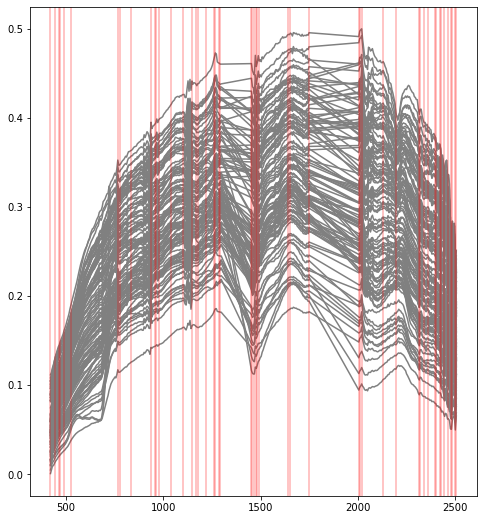

In [19]:
plt.close()
fig, ax = plt.subplots(figsize=(8, 9))
ax.plot(wl, X.T, color="gray")
[
    plt.axvline(x=wl[i], color='r', alpha=0.3, label='axvline - full height')
    for i in I
]
plt.savefig("./reports/figures/selected_bands.png")

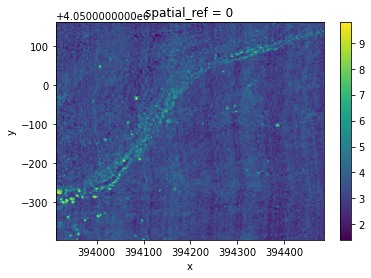

In [20]:
plt.close()
nitrogen_map.plot.imshow()
plt.savefig("./reports/figures/nitrogen_map.png")